## оценивать влияние распределения токов дволь дендрита на одиночные и суммарные ВПСП по:
 - dV/dt rise
 - Vmax
 - width 1/4, 1/2, 3/4
 - donductance velocity?
 - sag ('afterhypolarisatoin') amplitude, summation degree...
 -else?
 ## for sum of EPSPs:
 - summation degree
 
(по Angello et al...)

In [1]:
from lmfit import minimize, Parameters
import pandas

In [2]:
import sys
sys.path.append('/Applications/NEURON-7.4/nrn/lib/python')

In [3]:
from itertools import chain
%pylab inline
#%pylab tk

style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [4]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [5]:
from neuron import h, gui

h.celsius = 33.0

In [6]:
def find_nearest(array, value):

    idx = np.abs(array - value).argmin()
    return idx

In [7]:
# number of segments per dendrite should be large to allow for precise synapse location


Ndend = 4
    
class OctopusCell:
    all_currents = ['leak', 'nasab', 'kltab', 'khtab', 'ihsab']
    '''
    __init__() excecutes:
        - make_soma()
        - make_axon()
        - make_dendrites()
        - make_connections()
        - init_mechanisms()
        - add_stim()
        - init_records()
    '''
    def __init__(self, 
                 soma_diam=25.0,
                 ax_init_L=6.0,
                 ax_passive_L=35.0,
                 ax_diam=3.0,
                 Ndend=4, Ndendseg = 201, dend_L=250., dend_diam=3.0,
                 ax_gbar_na = 1600,  # mS/cm^2
                 ax_gbar_Ikl = 10,
                 soma_gbar_Ikl = 40.7, # mS/cm^2
                 soma_gbar_Ih = 7.6,   # mS/cm^2
                 dend_gbar_Ikl = 2.7,  # mS/cm^2 ; Table 3 Spencer 2012
                 dend_gbar_Ih = 0.6,   # mS/cm^2 ; Table 3 Spencer 2012
                 cm = 1.2, # uF/cm^2, closer to McGinley et al 2012
                 Ra = 150., #Ohm*cm, closer to McGinley et al 2012 
                 Eleak=-62):
        self.id = randint(10000000)
        #self.Eleak = Eleak
        self.make_soma(soma_diam)
        self.make_axon(ax_init_L, ax_passive_L,ax_diam)
        self.make_dendrites(Ndend,Ndendseg,dend_L,dend_diam)
        self.make_connections()
        self.init_mechanisms(ax_gbar_na, ax_gbar_Ikl,
                             soma_gbar_Ikl, soma_gbar_Ih,
                             dend_gbar_Ikl, dend_gbar_Ih,
                             cm, Ra, Eleak)
        
        self.add_stim()
        self.init_records()
        
    def add_stim(self):
        self.stim = h.IClamp(0.5, sec=self.soma)
        self.stim.amp = 0
        
    def init_records(self):
        istim = h.Vector()
        istim.record(self.stim._ref_i)
        self.istim = istim
        
        self.tv = h.Vector()
        self.tv.record(h._ref_t) 
        
        self.vax = h.Vector()
        self.vax.record(self.ax_init(0.5)._ref_v) 
        
        self.vs = h.Vector()
        self.vs.record(self.soma(0.5)._ref_v) 
        
#     def init_records(self, dnm=0):
        
#         self.T = h.Vector()
#         self.T.record(h._ref_t)
        
#         # dendrites records:
#         sec = self.dendrites[dnm]
#         self.Vsd = []
#         for seg in sec.allseg():
#             x = seg.x
#             self.v = h.Vector()
#             self.v.record(seg._ref_v)
#             self.Vsd.append(self.v)


        
        
    def make_soma(self,diam):
        # Soma
        soma = h.Section(name='soma_%d'%self.id)
        soma.L = soma.diam = diam
        soma.nseg = 1
        self.soma = soma

    def make_axon(self, ax_init_len=10, ax_passive_len=30,diam=3.0):
        # Axon
        ax_stub = h.Section(name='ax_stub%d'%self.id)
        ax_init = h.Section(name='ax_init%d'%self.id)
        ax_stub.diam = ax_init.diam = diam
        ax_stub.L = ax_passive_len
        ax_init.L = ax_init_len
       
        ax_init.nseg = int(ceil(ax_init.L/10))
        ax_stub.nseg = int(ceil(ax_stub.L/10))
        
        self.ax_init = ax_init
        self.ax_stub = ax_stub
    

    def make_dendrites(self,  Ndend=4, Ndendseg=201, L=250, diam=3.0):
        # Dendrites
        dendrites = [h.Section(name='dend_%d_%d'%(i,self.id)) for i in range(Ndend)]
        for d in dendrites:
            d.diam = 3
            d.L = L
            d.nseg = Ndendseg
            #d.connect(soma, 1, 0)
        self.dendrites = dendrites
    
    def make_connections(self):
        self.ax_init.connect(self.ax_stub, 1, 0)   # childsec.connect(parentsec, parentx, childx)
        self.ax_stub.connect(self.soma, 0, 0)
        for d in self.dendrites:
            d.connect(self.soma, 1, 0)
    
    def init_mechanisms(self, 
                        ax_gbar_na, ax_gbar_Ikl,
                        soma_gbar_Ikl, soma_gbar_Ih,
                        dend_gbar_Ikl, dend_gbar_Ih, 
                        cm, Ra, Eleak):
        sections = [self.soma, self.ax_init, self.ax_stub]+self.dendrites
        for sec in sections:
            sec.Ra = Ra  
            #sec.cm = 0.9      # Spencer
            sec.cm = cm      
            for cur in self.all_currents:
                sec.insert(cur)
            for seg in sec:
                seg.leak.erev = Eleak
                seg.leak.g = 0.002  # Spencer
                seg.ihsab.eh = -38 # Spencer
            
                seg.nasab.gbar = 0
                seg.ihsab.gbar = 0
                seg.kltab.gbar = 0
                seg.khtab.gbar = 0
            
            sec.ena = 55.0
            sec.ek = -70.0
    
        # ... there must be a more compact way...
        # todo: tabulate these parameters
        #for seg in self.ax_stub:
        #    seg.leak.g = 0
        for seg in self.ax_init:
            seg.nasab.gbar = ax_gbar_na*1e-3
            seg.kltab.gbar = ax_gbar_Ikl*1e-3
       
        for seg in self.soma:
            seg.kltab.gbar = soma_gbar_Ikl*1e-3
            seg.ihsab.gbar = soma_gbar_Ih*1e-3
            seg.khtab.gbar = 0.0061
            
    
        for seg in chain(*self.dendrites):
            seg.kltab.gbar = dend_gbar_Ikl*1e-3
            seg.ihsab.gbar = dend_gbar_Ih*1e-3
            
    def set_hcur_ddistribution(self, distrib):
        for seg in chain(*self.dendrites):
            seg.ihsab.gbar = distrib(seg.x) # generalize tow every current

    
    def delete(self):
        self.soma = None
        self.ax_init = None
        self.ax_stub = None
        self.dendrites = None
    
    def add_synapses(self,
                     Nsyn = 100, # total number of impinging synapses
                     gsyn = 1.5, # single synaptic conductance nS
                     tau_rise = 0.07,
                     tau_decay = 0.34,
                     #-- 
                     tonotopy = 'ordered', # {ordered, random}
                     full_delay = 0.3, # max difference between delays, ms
                     #--
                     aud_rate=211,    # incoming spike rate, Hz
                     aud_start = 100, # ms
                     aud_npulses=25,  # number of incoming spikes 
                     aud_jitter = 0.0, # jitter of incoming spike times (0...1)
                    ):
        afib = h.NetStim()

        afib.interval = 1000./aud_rate # ms 
        afib.start = aud_start # ms
        afib.number = aud_npulses # number of spikes
        afib.noise = aud_jitter # no randomness so far
        self.afib = afib
        
        synapses = []
        delays = linspace(0,full_delay, Nsyn) # !!! Delay distribution could be non-uniform!
        #delays = uniform(0.0,full_delay,size=Nsyn) # !!! Delay distribution could be non-uniform!
        for k in xrange(Nsyn):
            delay = delays[k]
            if tonotopy == 'ordered':
                loc = 1 - delay/full_delay
            elif tonotopy == 'random':
                loc = uniform()
#             d = self.dendrites[randint(len(self.dendrites))]
            d = self.dendrites[0] # for today, 18.03.17
            syn = h.Exp2Syn(loc, sec=d) 
            syn.tau1 = tau_rise # rise time
            syn.tau2 = tau_decay # decay time
            con  = h.NetCon(afib, syn, 0, delay, gsyn*1e-3) #nS->uS
            synapses.append((syn, con, d(loc), delay))
        self.synapses = synapses
        return
    def _shuffle_synapses(self):
        if not self.synapses:
            return
        for syn,con,seg in self.synapses:
            d = self.dendrites[randint(len(self.dendrites))]
            loc = uniform()
            #....syn.

#################################################################_OZ_16.02.17

    def set_afib(self,
                 aud_rate=211,    # incoming spike rate, Hz
                 aud_start=200, # ms
                 aud_npulses=25,  # number of incoming spikes 
                 aud_jitter=0.0, # jitter of incoming spike times (0...1)):
                 ):
        afib = h.NetStim()
        afib.interval = 1000./aud_rate # ms 
        afib.start = aud_start # ms
        afib.number = aud_npulses # number of spikes
        afib.noise = aud_jitter # no randomness so far
        self.afib = afib
        return afib
    
    
    def add_single_syn(self,
                       loca, # location [0...1] of the synapse
                       afib,
                       gsyn = 1.5, # single synaptic conductance nS
                       tau_rise = 0.07,
                       tau_decay = 0.34,
                       tonotopy = 'ordered', # {ordered, random}
                       delay_func=None,
                       dnm=0   # indice of a dend from the dendrites list
                     ):
        
        # Make a synapse
        d = self.dendrites[dnm]
        syn = h.Exp2Syn(loca, sec=d)
        syn.tau1 = tau_rise # rise time
        syn.tau2 = tau_decay # decay time

        if tonotopy == 'ordered':
            if delay_func == None:
                delay = 0 # ******** To Be Corrected Later ******* ???? Make a linear distr
            else:
                delay = delay_func(loca)
        elif tonotopy == 'random' and delay_func != None:
            delay = uniform(delay_func(0), delay_func(1))

#         print loca,delay

        con = h.NetCon(afib, syn, 0, delay, gsyn*1e-3) #nS->uS            
#         self.syn=syn
#         self.con=con
        
        synapse = (syn,con,d(loca),delay)
        self.synapse = synapse
        return synapse


    def add_several_syn(self,
                        locs,  
                        gsyn = 1.5, # single synaptic conductance nS
                        tau_rise = 0.07,
                        tau_decay = 0.34,
                        tonotopy = 'ordered', # {ordered, random}
                        delay_func=None,
                        afibp=dict(aud_rate=211,   
                                   aud_start=200,   
                                   aud_npulses=1,    
                                   aud_jitter=0.0), 
                        dnm=0,
                       ):
        afib = self.set_afib(**afibp)
        synapses=[]
        if type(dnm) == int:
#             print 'dnm is INT MFFCR!'
            for loc in locs:
                synapses.append(self.add_single_syn(loca=loc,
                                                    afib=afib,
                                                    gsyn=gsyn,
                                                    tau_rise=tau_rise,
                                                    tau_decay=tau_decay,
                                                    tonotopy=tonotopy,
                                                    delay_func=delay_func,
                                                    dnm=dnm
                                                   )
                                )
            self.synapses=synapses
            
        elif type(dnm) == list:
#             for d in dnm:
            for loc in locs: # now locs are the coordinates of all synapses to be distributed 
                             # amond all dends with indices from dnm
                d = dnm[randint(len(dnm))]
                synapses.append(self.add_single_syn(loca=loc,
                                                afib=afib,
                                                gsyn=gsyn,
                                                tau_rise=tau_rise,
                                                tau_decay=tau_decay,
                                                tonotopy=tonotopy,
                                                delay_func=delay_func,
                                                dnm=d
                                               )
                            )
            self.synapses=synapses
        
        return
    
    def find_delays(self,
                    locs, # locs: .0->1.
                    v_init=-61.1,
                    afibp=dict(aud_rate=211,   
                               aud_start=300,  
                               aud_npulses=1,  
                               aud_jitter=0.0),
                    dnm=0,
                   ):
        acc=[]
        acc1=[]
        afib=self.set_afib(**afibp)

        for loc in locs:
            self.add_single_syn(loca=loc, afib=afib, dnm=dnm,gsyn=10.)
            # *.add_single_syn overwrites *Dend.synapse* variable at every iteration. The last is not deleted

            vx = h.Vector()
            vx.record(self.dendrites[dnm](loc)._ref_v)
            v0 = h.Vector()
            v0.record(self.dendrites[dnm](0.0)._ref_v)   # 'destination' region (0.0 fixed to soma(1))
            t = h.Vector()
            t.record(h._ref_t)

            h.tstop = 400
            h.v_init = v_init
            h.run()
            
#             print array(v0).max(), array(v1).max()

            t_ = find_nearest(array(t),100)  # indice to begin reading Vs from, avoiding relaxation, what may be higher than EPSP
#             print t_, array(vx)==array(vx)[t_:].max(), array(vx)==array(vx).max()
        
            tx_max = array(t)[array(vx)==array(vx)[t_:].max()]  # time when Vm reaches max at the *loc* coordinate
            t0_max = array(t)[array(v0)==array(v0)[t_:].max()]  # -||- at the 'destination' coordinate 
            taux = tx_max-afibp['aud_start']                    # the time of Vmax appear at the x coordinate relatively to aud_start moment
#             print t0_max, t1_max
            
            acc.append([loc,
#                         t1_max-afibp['aud_start'],
#                         t1_max-tx_max])   # synapse location and corresponding delay times, both relative to
                        t0_max])                                           # aud_start and t0_max
            acc1.append(map(array, [t,vx,v0]))
        acc = transpose(acc)
        return acc, acc1
        

In [8]:
def records(cell):
    vs = h.Vector()
    vd01 = h.Vector()
    vd09 = h.Vector()
    va = h.Vector()
    
    vs.record(cell.soma(.5)._ref_v)
    vd01.record(cell.dendrites[0](0.1)._ref_v)
    vd09.record(cell.dendrites[0](0.9)._ref_v)
    va.record(cell.ax_init(.5)._ref_v)
    
    t = h.Vector()
    t.record(h._ref_t)

    h.run()
    cell.Vs = {key:val for key, val in zip(['t','soma','dend_01','dend_09','ax'], [t,vs,vd01,vd09,va])}
    return
    
def set_erev_leak(cell, erev):
    """
    Set erev_leak == `erev` throughout all sections of the cell
    """
    sections = [cell.soma,cell.ax_init,cell.ax_stub]+[d for d in cell.dendrites]
    for s in sections:
        s.erev_leak = erev

# to gain spatial Vm distr along dend use:
v_along_dend = lambda cell, xs: array([cell.dendrites[0](x).v for x in xs])

In [11]:
h.tstop = 700
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [15]:
#сколько времени нужно до стац сост?

oc = OctopusCell(ax_init_L=6.)

In [12]:
records(oc)

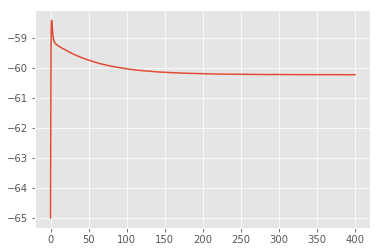

In [13]:
plot(oc.Vs['t'],oc.Vs['dend_1'])

In [14]:
oc.delete()
del oc

# => Стимул на 300 мс норм

In [47]:
oc.delete()
oc1.delete()
oc2.delete()
del oc,oc1,oc2

In [156]:
oc = OctopusCell(ax_init_L=6., soma_gbar_Ih=0, dend_gbar_Ih=0)
oc1 = OctopusCell(ax_init_L=6.)
oc2 = OctopusCell(ax_init_L=6.) # Erev_leak changed


In [57]:
set_erev_leak(oc2, -76)

In [157]:
for c in [oc,oc1,oc2]:
    c.add_synapses(Nsyn=1,aud_npulses=1,aud_start=600)

In [159]:
h.tstop = 700

In [160]:

records(oc)
records(oc1)
records(oc2)

In [161]:
# where to shift tow zero
t_norm = find_nearest(array(oc.Vs['t']),599)

# Подбор `erev_leak` осмы: при `gbar_h = 0` и `≠ 0` стационарное значение `V_m` одинаково

In [11]:
def residual(p,cell,  v_init, eps, output=None):
    erev_leak_init = cell.soma.erev_leak # record init erev_leak to be able to return back from (*)
    par = p['par']
    model = erev_leak_init + par # define a new *erev_leak
    set_erev_leak(cell, model) # set the cell.erev_leak to be the *erev_leak (*)
    h.dt = 0.1
    h.run()
    v_new = cell.soma.v # see new soma voltage
    if output == 'y':
        print 'v_init %.6f, v_new %.6f'%(v_init, v_new)
    set_erev_leak(cell, erev_leak_init) # return back to init erev_leak
    return (v_init-v_new)/eps # see the difference between initial V (data) and V_new after erev_leak change 

In [164]:
p = Parameters()
p.add(name='par',value=-10)
v_init = oc.soma.v
eps = 1
output =None

In [166]:
out = minimize(residual, p, args=(oc2, data, eps, output))

In [168]:
set_erev_leak(oc2,erev=-62+out.params['par']) # set new erev_leak

In [169]:
records(oc)
records(oc2)

(599, 610)

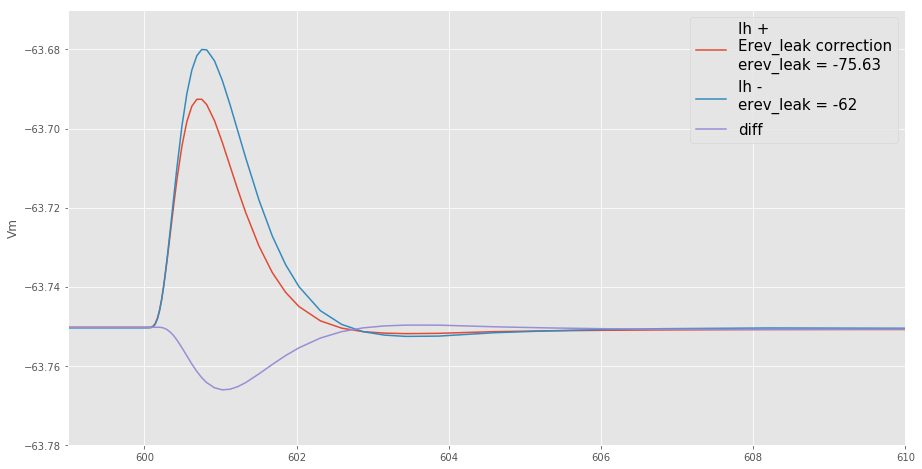

In [222]:
figure(figsize=(15,8))
plot(oc2.Vs['t'],oc2.Vs['soma'],label='Ih + \nErev_leak correction\nerev_leak = -75.63')
plot(oc.Vs['t'],oc.Vs['soma'],label='Ih - \nerev_leak = -62')
t_norm = find_nearest(array(oc.Vs['t']),599)
diff = array(oc2.Vs['soma'])-array(oc.Vs['soma'])
plot(oc.Vs['t'],diff+oc.Vs['soma'][t_norm], label='diff')
ylabel('Vm')
legend(fontsize=15)
ylim(-63.78,-63.67)
xlim(599,610)

# Tow. whole cell erev_leak corerction

In [21]:
oc = OctopusCell(ax_init_L=6., soma_gbar_Ih=0, dend_gbar_Ih=0)
oc1 = OctopusCell(ax_init_L=6.) # erev_leak correction
oc2 = OctopusCell(ax_init_L=6.) # Gh distrib chng + erev_leak correction

In [22]:
oc2.set_hcur_ddistribution(lambda x: 0.0003 + x*0.0006)

In [21]:
h.tstop = 700
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [23]:
h.run()

0.0

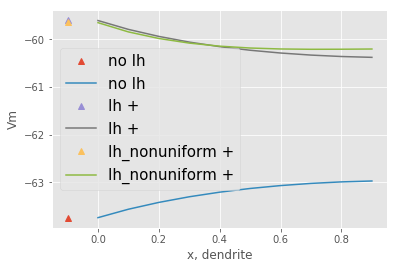

In [19]:
plot(-0.1,oc.soma.v,'^',arange(0,1,0.1),v_along_dend(oc,arange(0,1,0.1)),label='no Ih')
plot(-0.1,oc1.soma.v,'^',arange(0,1,0.1),v_along_dend(oc1,arange(0,1,0.1)),label='Ih +')
plot(-0.1,oc2.soma.v,'^',arange(0,1,0.1),v_along_dend(oc2,arange(0,1,0.1)),label='Ih_nonuniform +')
ylabel('Vm')
xlabel('x, dendrite')
legend(loc='best',fontsize=15)

Что сделать -- свести   `oc1.Vm`   к `oc.Vm`, подобрав подходящее значение `erev_leak`  в каждом сегменте

In [9]:
# for whole cell
def residual_d(p, cell,  v_inits, eps, mode='linear', mode2='res', show_res=None):
    """
    `mode` -- chose the func to be added to erev_leak spatial distribution => v_new = v_init.
    `mode2 -- chose the regime: 
        - 'res'=> residual calculated and erev_leak of cell's dendrites
        remain not to be changed, residual returned; 
        - 'clac' => change dends erev_leak distrib
    """
    erev_leak_init = cell.dendrites[0].erev_leak # record init erev_leak to be able to return back from (*)
    nseg = cell.dendrites[0].nseg


#     free = p['free']
#     slp = p['slope']
#     if mode = 'exp':
#         slp2 = p['slope2']
#         add = p['add']

#     for d in cell.dendrites:
#         for seg in d:
    for seg in chain(*cell.dendrites):
        if mode == 'linear':
            delta = p['free'] + p['slope1']*seg.x
        elif mode == 'exp':
            delta = p['free'] + p['slope1']*exp(p['slope2']*seg.x+p['add'])
        elif mode == 'parab':
            delta = p['free'] + p['slope1']*(p['slope2']*seg.x + p['add'])**2
        seg.erev_leak += delta # set new dnd.erev_leak
    cell.soma.erev_leak += p['s']
    cell.ax_init.erev_leak += p['ai']
    cell.ax_stub.erev_leak += p['ast']
    
    h.dt = 0.1
    if mode2 == 'res':
        h.run()
        v_new = v_along_dend(cell, arange(0,1,0.1)) # rec new voltage along dend
    #     if output == 'y':
    #         print 'v_init %.6f, v_new %.6f'%(v_init, v_new)
        set_erev_leak(cell, erev_leak_init) # return back teh cell to initial erev_leak
        resd = v_inits['dnd'] - v_new # see the difference between initial V (data) and V_new after erev_leak was changed
        ress = v_inits['sma'] - cell.soma.v # take into account axon and soma voltages
        resa = v_inits['axn'] - cell.ax_init.v
        res = array(list(resd) +  [ress,resa])
        if show_res == True:
            print res
        return res/eps
    
    elif mode2 == 'calc':
        return 

In [12]:
p = Parameters()
p.add(name='free', value=-10)
p.add(name='slope1', value=0.1)
p.add(name='slope2', value=-1)
p.add(name='add', value=1)
p.add(name='s',value=-10,min=-30,max=30)
p.add(name='ai',value=-10, min=-30,max=30)
p.add(name='ast',value=-10, min=-30,max=30)

In [53]:
set_erev_leak(oc1, -62)
h.run()

0.0

In [54]:
v_inits = {'dnd':v_along_dend(oc,arange(0,1,0.1)),'sma':oc.soma.v,'axn':oc.ax_init.v}
eps = 10
mode = 'linear'
mode2 = 'res'

In [55]:
out1 = minimize(residual_d, p, args=(oc1,v_inits,eps, mode))
# out2 = minimize(residual_d, p, args=(oc2,v_inits,eps, mode))

[-1.09821332 -0.12462091  0.64889001  1.27639347  1.78052187  2.17952004
  2.48788818  2.71689364  2.87496968  2.96801484 -1.1286105  -0.75858788]
[-1.09821332 -0.12462091  0.64889001  1.27639347  1.78052187  2.17952004
  2.48788818  2.71689364  2.87496968  2.96801484 -1.1286105  -0.75858788]
[-1.09821332 -0.12462091  0.64889001  1.27639347  1.78052187  2.17952004
  2.48788818  2.71689364  2.87496968  2.96801484 -1.1286105  -0.75858788]
[-1.09821335 -0.12462095  0.64888995  1.27639341  1.78052181  2.17951997
  2.48788811  2.71689356  2.87496961  2.96801476 -1.12861053 -0.75858791]
[-1.09821332 -0.12462091  0.64889001  1.27639347  1.78052187  2.17952004
  2.48788818  2.71689364  2.87496968  2.96801484 -1.1286105  -0.75858788]
[-1.09821332 -0.12462091  0.64889001  1.27639347  1.78052187  2.17952004
  2.48788818  2.71689364  2.87496968  2.96801484 -1.1286105  -0.75858788]
[-1.09821332 -0.12462091  0.64889001  1.27639347  1.78052187  2.17952004
  2.48788818  2.71689364  2.87496968  2.96801

KeyboardInterrupt: 

In [48]:
out1.params

Parameters([('free',
             <Parameter 'free', value=-3.6252230067261566 +/- 0, bounds=[-inf:inf]>),
            ('slope1',
             <Parameter 'slope1', value=441.26438326049305 +/- 0, bounds=[-inf:inf]>),
            ('slope2',
             <Parameter 'slope2', value=1.4894884739311549 +/- 0, bounds=[-inf:inf]>),
            ('add',
             <Parameter 'add', value=-4412.1491466181023 +/- 0, bounds=[-inf:inf]>),
            ('s',
             <Parameter 's', value=-29.999999998477296 +/- 0, bounds=[-30:30]>),
            ('ai',
             <Parameter 'ai', value=6.1940982753035456 +/- 0, bounds=[-30:30]>),
            ('ast',
             <Parameter 'ast', value=-29.999999996047269 +/- 0, bounds=[-30:30]>)])

In [30]:
residual_d(out1.params, cell=oc1,v_inits=v_inits,eps=1,mode='linear', mode2='calc')
# residual_d(out2.params, cell=oc2,v_inits=v_inits,eps=1,mode='linear', mode2='calc')

In [31]:
h.run()

0.0

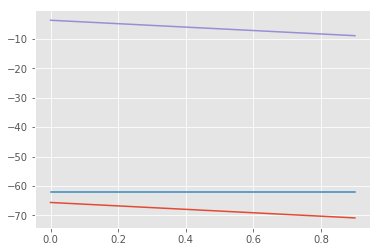

In [32]:
# see how erev_leak changed
plot(arange(0,1,0.1),[oc1.dendrites[0](x).erev_leak for x in arange(0,1,0.1)])
plot(arange(0,1,0.1),[oc.dendrites[0](x).erev_leak for x in arange(0,1,0.1)])
plot(arange(0,1,0.1),[oc1.dendrites[0](x).erev_leak-oc.dendrites[0](x).erev_leak for x in arange(0,1,0.1)])

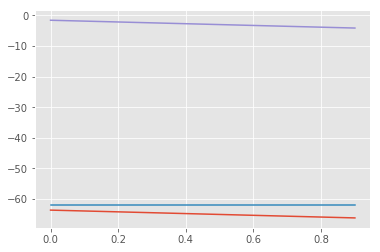

In [45]:
# see how erev_leak changed *** Ih distribution changed
plot(arange(0,1,0.1),[oc2.dendrites[0](x).erev_leak for x in arange(0,1,0.1)])
plot(arange(0,1,0.1),[oc.dendrites[0](x).erev_leak for x in arange(0,1,0.1)])
plot(arange(0,1,0.1),[oc2.dendrites[0](x).erev_leak-oc.dendrites[0](x).erev_leak for x in arange(0,1,0.1)])

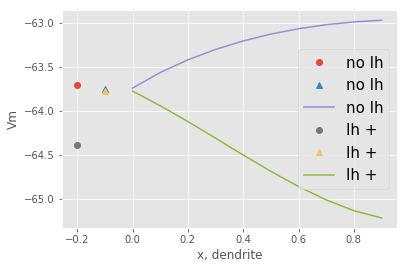

In [35]:
plot(-0.2,oc.ax_init.v,'o',-0.1,oc.soma.v,'^',arange(0,1,0.1),v_along_dend(oc,arange(0,1,0.1)),label='no Ih')
plot(-0.2,oc1.ax_init.v,'o',-0.1,oc1.soma.v,'^',arange(0,1,0.1),v_along_dend(oc1,arange(0,1,0.1)),label='Ih +')
# plot(-0.2,oc1.ax_init.v,'o',-0.1,oc2.soma.v,'^',arange(0,1,0.1),v_along_dend(oc2,arange(0,1,0.1)),label='Ih_nonuniform +')
ylabel('Vm')
xlabel('x, dendrite')
legend(loc='best',fontsize=15)

In [ ]:
# TRY chng initial parameters

# Работает! Можно менять распределение Ih дендритов и подбирать Erev_leak так, тчобы Vm при всех распределениях был одинаков. *Note* На дендритах res_func меняет e_leak много меньше, чем на соме и аксоне. Возможны проблемы с размытием ВПСП, на соме

# Посмотрим на одиночный ВПСП. Выхвать ВПСП в конце дендрита, rec Vm(t) в конце дендрита, в его начале и в соме. Для трех вариантов: noIh, Ih_uniform, Ih_lineargrad.

In [50]:
oc.delete()
oc1.delete()
oc2.delete()
del oc,oc1,oc2

NameError: name 'oc' is not defined

# *Algorythm

In [11]:
# 1. make cells
oc = OctopusCell(soma_gbar_Ih=0, dend_gbar_Ih=0) # no Ih
oc1 = OctopusCell() # just Ih + erev_leak norm
oc2 = OctopusCell() # Ih linear gradient towards distal dend ends+ erev_leak norm
oc2.set_hcur_ddistribution(lambda x: 0.0003 + x*0.0006)

In [25]:
# 2. relax cells during >400 ms
h.run()

0.0

In [41]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [26]:
# 3. adjust Vm to be equal
# 3.1 prepare to fit
p = Parameters()
p.add(name='free', value=-10)
p.add(name='slope1', value=-0.1)
p.add(name='slope2', value=1)
p.add(name='add', value=1)
p.add(name='saa',value=-13)

v_init = v_along_dend(oc,arange(0,1,0.1))
eps = .1
mode = 'linear'
mode2 = 'res'


In [32]:
# 3.2 provide fit
out1 = minimize(residual_d, p, args=(oc1,v_init,eps, mode))
out2 = minimize(residual_d, p, args=(oc2,v_init,eps, mode))

In [33]:
# 4. set the new erev_leaks in oc1 and oc2
residual_d(out1.params, cell=oc1,v_init=v_init,eps=1,mode='linear', mode2='calc')
residual_d(out2.params, cell=oc2,v_init=v_init,eps=1,mode='linear', mode2='calc')

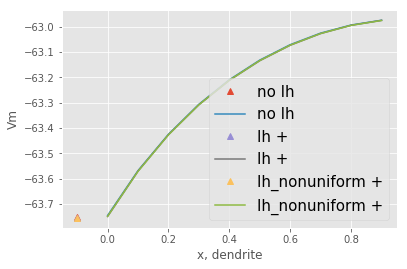

In [35]:
# 4.1 check for equality of Vms
h.tstop = 700
h.run()
plot(-0.1,oc.soma.v,'^',arange(0,1,0.1),v_along_dend(oc,arange(0,1,0.1)),label='no Ih')
plot(-0.1,oc1.soma.v,'^',arange(0,1,0.1),v_along_dend(oc1,arange(0,1,0.1)),label='Ih +')
plot(-0.1,oc2.soma.v,'^',arange(0,1,0.1),v_along_dend(oc2,arange(0,1,0.1)),label='Ih_nonuniform +')
ylabel('Vm')
xlabel('x, dendrite')
legend(loc='best',fontsize=15)

In [ ]:
# all curves and soma (∆) are supperimposed -- OK!

In [42]:
# 5. add synapses and record
for c in [oc,oc1,oc2]: 
    # in self.add_synapses changed "syn in dendrites[randint]" -> "... dendrites[0]" for this issue 18.03.17
    # cause records func does record Vm only in dendrites[0]
    c.add_synapses(Nsyn=350,aud_npulses=1,aud_start=600)

records(oc)
records(oc1)
records(oc2)

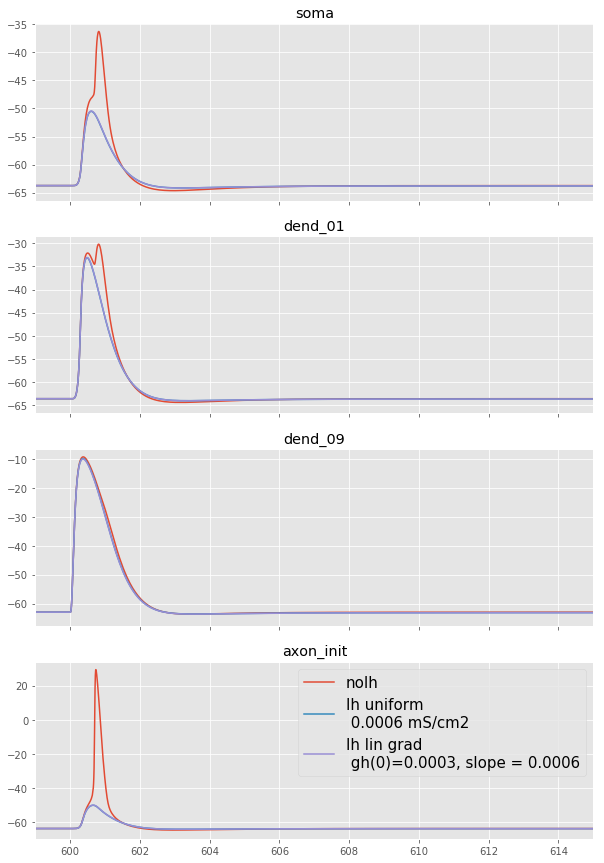

In [44]:
# 6. Plot some Vs...
cells = [oc,oc1,oc2]
lbls = ['noIh','Ih uniform\n 0.0006 mS/cm2', 'Ih lin grad \n gh(0)=0.0003, slope = 0.0006']

f,ax = subplots(4,1, sharex=True,figsize=(10,15))
for c,l in zip(cells, lbls):
    ax[0].plot(c.Vs['t'],c.Vs['soma'], label=l)
    ax[0].set_title('soma')
    ax[1].plot(c.Vs['t'],c.Vs['dend_01'], label=l)
    ax[1].set_title('dend_01')
    ax[2].plot(c.Vs['t'],c.Vs['dend_09'], label=l)
    ax[2].set_title('dend_09')
    ax[3].plot(c.Vs['t'],c.Vs['ax'], label=l)
    ax[3].set_title('axon_init')
xlim(599,615)
legend(fontsize=15)
# ax[0].set_ylim(-63.8,-63.3)
# ax[1].set_ylim(-63.8,-63.3)
# ax[2].set_ylim(-63,-61.5)

# Now see the temporal summation:

In [127]:
# 5. add synapses and record
for c in [oc,oc1,oc2]: 
    # in self.add_synapses changed "syn in dendrites[randint]" -> "... dendrites[0]" for this issue 18.03.17
    # cause records func does record Vm only in dendrites[0]
    c.add_synapses(Nsyn=1,aud_npulses=5,aud_start=600,aud_rate=1000)

records(oc)
records(oc1)
records(oc2)

(-63.4, -62)

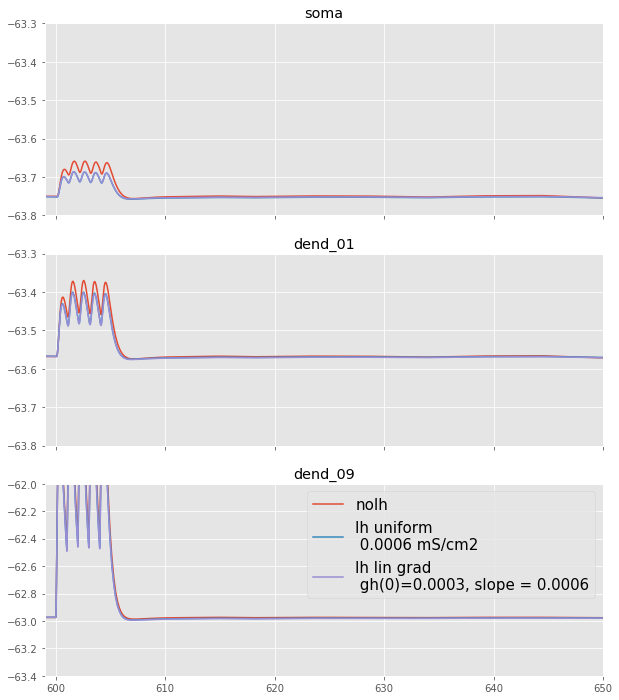

In [141]:
# 6. Plot some Vs...
cells = [oc,oc1,oc2]
lbls = ['noIh','Ih uniform\n 0.0006 mS/cm2', 'Ih lin grad \n gh(0)=0.0003, slope = 0.0006']
t_norm = find_nearest(array(oc.Vs['t']),599)
f,ax = subplots(3,1, sharex=True,figsize=(10,12))
for c,l in zip(cells, lbls):
    ax[0].plot(c.Vs['t'],c.Vs['soma'], label=l)
    ax[0].set_title('soma')
    ax[1].plot(c.Vs['t'],c.Vs['dend_01'], label=l)
    ax[1].set_title('dend_01')
    ax[2].plot(c.Vs['t'],c.Vs['dend_09'], label=l)
    ax[2].set_title('dend_09')
# ax[0].plot(oc.Vs['t'],-array(oc.Vs['soma'])+array(oc1.Vs['soma'])+oc.Vs['soma'][t_norm])
# ax[1].plot(oc.Vs['t'],-array(oc.Vs['dend_01'])+array(oc1.Vs['dend_01'])+oc.Vs['dend_01'][t_norm])
# ax[2].plot(oc.Vs['t'],-array(oc.Vs['dend_09'])+array(oc1.Vs['dend_09'])+oc.Vs['dend_09'][t_norm])
xlim(599,650)
legend(fontsize=15)
ax[0].set_ylim(-63.8,-63.3)
ax[1].set_ylim(-63.8,-63.3)
ax[2].set_ylim(-63.4,-62)

In [ ]:
##############################

In [230]:
oc1.set_hcur_ddistribution(lambda x: 0.0003 + x*0.0006) # linear Gh slope tow X=1

In [10]:
def rec_hcur_profile(cell):
    Curs = []
    Xs = []
    cond =[]
    Vs = []
    for s in cell.dendrites[0]:
        Curs.append(s.ihsab.ih)
        Xs.append(s.x)
        cond.append(s.ihsab.gbar)
        Vs.append(s.v)
    return [Xs,Curs,cond,Vs]

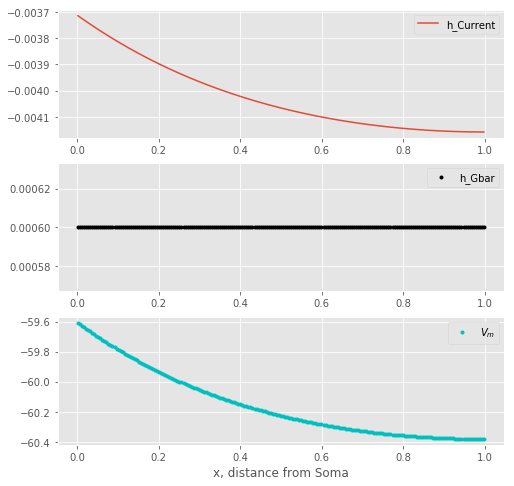

In [263]:
Ihoc = rec_hcur_profile(oc)
# title='Uniform h_Gbar'
figure(figsize=(8,))

subplot(311)
plot(Ihoc[0],Ihoc[1], label='h_Current')
legend()
subplot(312)
plot(Ihoc[0],Ihoc[2], 'k.',label='h_Gbar')
legend()
subplot(313)
plot(Ihoc[0],Ihoc[3], 'c.',label='$V_m$')
legend()
xlabel('x, distance from Soma')





# Instruments to dv/dt, halfwidth etc calculation

In [11]:

import math

def pop_equal(data):
    if type(data) != list:
        data = list(data)
    for i in range(len(data)):
        if data[i] == data[i-1]:
            data[i] = (data[i+1] + data[i-1])/2.
    return array(data)

def deriv(x,y):

    count=[0,0]
    if len(y) != len(x):
        return 'Y and X length are different!'
    x = pop_equal(x) # violate nan and inf values
    y = pop_equal(y)
    
    deriv = []
#     print len(y)
    for i in range(len(y)-1):
        der = (y[i+1]-y[i])/(x[i+1]-x[i])
        if math.isnan(der) == True:
            count[0] += 1
            der = deriv[i-1] # change every NaN to the previous value. Max() cannot be found if there are NaNs
                                # The previous vlue is chosen as on a certain interval NaNs interchange with non-Nan
        elif der == inf:
            count[1] += 1
            der = deriv[i-1] # Secure from inf
        deriv.append(der)
        
    deriv.append(deriv[-1])
    return array(deriv), count

def cut_n_deriv(xarr, yarr, x_boarders):
    [xarr, yarr] = map(array, [xarr, yarr])
    idxb0 = map(lambda x: find_nearest(xarr,x), x_boarders)
#     print idxb0
    # Cut curve from left and right. Make yarrn for `actual boarders` determine
    yarrn = yarr[idxb0[0]:idxb0[1]]
    xarrn = xarr[idxb0[0]:idxb0[1]]
#     print yarrn, xarrn
    tail = len(yarr[:idxb0[0]]) # how much is cut from the left. 
    dyarrn = deriv(xarrn, yarrn)[0]
    return dyarrn, yarrn, xarrn

def rate_depol(xarr, yarr, x_boarders, lvls=[1/2.,3/4.], see=0):
    dyarrn, yarrn, xarrn = cut_n_deriv(xarr, yarr, x_boarders)
#     kepvar = ['vr1/4', 've1/2', 've3/4','vd1/4', 'vd1/2', 'vd3/4'] # rise and decay dV/dt's
#     acc = dict()
    ma = yarrn.max()
    lvls = array(lvls)
    lvls = {str(key):val for key, val in zip(lvls,(yarrn[0] + abs(ma-yarrn[0])*lvls))}
    xma = yarrn.argmax() # index of yarrn.max
    lvlidx = {key:find_nearest(yarrn[:xma],lvls[key]) for key in lvls.keys()}
    
#     xhalfma = find_nearest(yarrn[:xma],lvls['1/2']) # index: where halfmax abscissa on the rising phase
#     xfourthma = find_nearest(yarrn[:xma],lvls['3/4']) 

    dvdts = {key:dyarrn[lvlidx[key]] for key in lvls.keys()}
#     dvdt_half = dyarrn[xhalfma]
#     dvdt_fourth = dyarrn[xfourthma]
    if see == 1:
        figure()
        plot(xarrn,yarrn)
        axhline(ma)
#         axhline(xhalfma)
#         axhline(xfourthma)
        axvline(xarrn[xma])
#         axvline(xarrn[xhalfma])
#         axvline(xarrn[xfourthma])
        for key in lvls.keys():
            axvline(xarrn[lvlidx[key]])
            
#     print lvls, lvlidx, dvdts
    return dvdts

def width(xarr, yarr, x_boarders,see=0):
    dyarrn, yarrn, xarrn = cut_n_deriv(xarr, yarr, x_boarders)
    ma = yarrn.max()
    half = (yarrn[0] + ma)/2.
    xma = yarrn.argmax() # index of yarrn.max
    tlr0 = find_nearest(yarrn[:xma], half)
    tlr1 = find_nearest(yarrn[xma:], half) + len(yarrn[:xma])
    width = xarrn[tlr1] - xarrn[tlr0]
    if see == 1:
        figure()
        plot(xarrn, yarrn)
        axvline(xarrn[tlr0])
        axvline(xarrn[tlr1])
        axhline(half)
#     print width
#     width_half = xarrn[find_nearest(yarrn[xma-1:], th/2.)] - xarrn[find_nearest(yarrn[:xma], th/2.)]
    
    return width

def V_peaks(xarr, yarr, x_boarders,see=0):
    """
    Returns absolute values of pick and sag amplitudes
    """
    dyarrn, yarrn, xarrn = cut_n_deriv(xarr, yarr, x_boarders)
#     ma = yarrn.max()
    xma = yarrn.argmax() # index of yarrn.max
    
    V0 = yarrn[0]
    Vmax = yarrn.max()
    Vsag = yarrn[xma:].min()
    
    if see==1:
        figure()
        plot(xarrn,yarrn)
        axhline(Vmax)
        axhline(Vsag)
        
    return abs(Vmax-V0), abs(Vsag-V0)

In [97]:
rate_depol(oc.Vs['t'], oc.Vs['soma'],x_boarders=[300,302],lvls=[1/2.])

{'0.5': -57.748130897240344} {'0.5': 252} {'0.5': 12.294700940373705}


{'0.5': 12.294700940373705}

In [44]:
oc.delete()


In [ ]:
del oc

In [45]:
oc = OctopusCell()

In [46]:
oc.add_synapses(Nsyn=250, gsyn=1.,aud_start=300, aud_npulses=1)

In [15]:

h.tstop=400

In [16]:
h.cvode_active(1)
h.cvode.atol(1e-5)

1e-05

In [21]:
records(oc)

In [22]:
for c in ['ax','soma','dend_01', 'dend_09']:
    vr = rate_depol(oc.Vs['t'],oc.Vs[c],[300,310])
    print vr

36.5859812869
39.3230931958
139.20422956
185.512798022


## set different Gh uniform an dsee slopes, halfwidth etc.

In [12]:
def params(cell, sec, see=0):
    """
    Use aud_npulses = 1
    Do records(cell)
    """
    records(cell)
    start = cell.afib.start # syn activation time
    dvdts = rate_depol(cell.Vs['t'], cell.Vs[sec], [start,start+3])
    keys = ['width', 'Vmax', 'Vsag'] + dvdts.keys()
    acc = {key:[] for key in keys}

    for key in dvdts.keys():
        acc[key].append(dvdts[key])
    acc['width'].append(width(cell.Vs['t'],cell.Vs[sec],[start,start+10]))
    V_ps = V_peaks(cell.Vs['t'],cell.Vs[sec],[start,start+20])
    acc['Vmax'].append(V_ps[0])
    acc['Vsag'].append(V_ps[1])
        
    return acc

In [13]:
p = Parameters()
p.add(name='free', value=-10)
p.add(name='slope1', value=0.1)
p.add(name='slope2', value=-1)
p.add(name='add', value=1)
p.add(name='s',value=-1,min=-3,max=3)
p.add(name='ai',value=-1, min=-3,max=3)
p.add(name='ast',value=-1, min=-3,max=3)

In [24]:
def vary_dcur(cell, sec, p, gbars, curs, eps=1, mode='linear', #g_func=...,
              see=0, mode2='chng',plot_par=None,plot_curves=None):
    """
    Wakl along gbars, set them to cur in dendrites, then change erate_leak for Vm=Vm...
    gbars = {'cur1name':[gbars1], 'cur2name':[gbars2], ...}
    
    cur = ['Ih', 'Ikl', ...]
    sec -- section ( 'ax','soma','dend_01' or 'dend_09' ) where params are calculated
    -----
    mode2 = 'chng' => new erev_leak computed and changed;
          ≠ 'chng' => nor computed not changed.
    -----
    see=1 => Visualize v_init and new v along dend
    """
    erev_leak_init = cell.soma.erev_leak
    g_init = cell.dendrites[0].gbar_ihsab # initial gbar value -- use to set afted parameters' values gain
    v_inits = {'dnd':v_along_dend(cell, arange(0,1,0.1)),
               'sma':cell.soma.v,
               'axn':cell.ax_init.v} # initial Vm in sections. After gbar change v_inits is the target to fit Vm
#     print v_inits,'\n erev_lk and gh_init', erev_leak_init, g_init
#     acc_erev_leak = dict()
    
    parkeys = ['width', 'Vmax', 'Vsag'] + ['0.5', '0.75']
    acc_pars = {key:[] for key in parkeys} # accumulate parameters' values
    
    for g in gbars:
        for seg in chain(*cell.dendrites):
            if cur == 'Ih':
                seg.gbar_ihsab = g #g_func(seg.x) # lambda x: gbar / ... # want to use a general func
            if cur == 'Ikl':
                seg.gbar_kltab = g
            
#         print 'NOW gh_bar = ', cell.dendrites[0].gbar_ihsab
        
        #----------- Calculate erev_leaks in cell sections that => Vm(gbar = init) = Vm(changed gbar)
        if mode2 == 'chng': 
            out = minimize(residual_d, p, args=(cell, v_inits, eps, mode))
    #         print out.params
            residual_d(out.params, cell=cell, v_inits=v_inits, eps=eps, mode=mode, mode2='calc') # set new erev_leak distrib
    #         h.run()
    
        #----------- Visualize v_init and new v along dend
        if see==1:  
            figure()
            plot(arange(0,1,0.1),v_inits['dnd'], label='target')
            plot(-0.1,oc.soma.v,'^',arange(0,1,0.1),v_along_dend(oc,arange(0,1,0.1)),label='Gh chnged')
            ylabel('Vm')
            xlabel('x, dendrite')
            legend(loc='best',fontsize=15)
            
        #----------- h.run and rec parameters
        pars = params(cell, sec)
        

        
        for k in pars.keys(): # keys are parameter names, 'dvdt' etc.
            acc_pars[k].append(pars[k][0]) # lists of parameters from different gbar
            
        for seg in chain(*cell.dendrites): # set erev_leaks and gbars back to initial values
            seg.gbar_ihsab = g_init
            seg.erev_leak = erev_leak_init
        cell.soma.erev_leak = erev_leak_init
        cell.ax_init.erev_leak = erev_leak_init
        cell.ax_stub.erev_leak = erev_leak_init
        
#         print '+NOW erev_leak and gh_bar = ', cell.dendrites[0].erev_leak, cell.dendrites[0].gbar_ihsab, 
#         print cell.soma.erev_leak, cell.dendrites[0].gbar_ihsab
    if plot_par == 1:
        f=figure(figsize=(7,3))
        title(sec)
        for key, val in acc_pars.items():
        #     figure(figsize=(7,2))
            plot(gbars, val/array(val).max(), 'o-', label=key)
        legend()
        xlabel('g_bars, mS/cm2')
        return acc_pars,f
    return acc_pars

In [16]:
oc = OctopusCell()
oc.add_synapses(Nsyn=250, gsyn=1.,aud_start=300, aud_npulses=1)

In [15]:
h.tstop = 400

Try width() with different values of dendrites.gbar_ihsab

# Look what happens with Vm when Gh is varied. No spiking desired

In [61]:
oc1.delete()

In [62]:
del oc1

In [14]:
oc1 = OctopusCell(Ndendseg=501)

In [16]:
oc1.add_several_syn(locs = linspace(0,1,75),gsyn=1.,dnm=[0,1,2,3],
                    afibp={'aud_npulses':1,'aud_start':300,'aud_jitter':0,'aud_rate':2})
# oc1.add_synapses(Nsyn=250, aud_npulses=1, aud_start=200,gsyn=1)



In [15]:
h.cvode_active(1)

1.0

In [18]:
h.cvode.atol(1e-3)

1e-10

In [17]:
h.tstop =400

In [59]:
# for d in oc1.dendrites:
#     d.gbar_ihsab = 0.0006

In [16]:
gh = {'soma':linspace(0.0038,0.0152,5),
     'dend': linspace(0.0003,0.0012,5)}
gkl = {'soma':linspace(0.00204,0.0814,5),
      'dend': linspace(0.0014,0.0054,5)}

#   soma_gbar_Ikl = 0.0407, # mS/cm^2
#                  soma_gbar_Ih = 0.0076,   # mS/cm^2
#                  dend_gbar_Ikl = 2.7, 

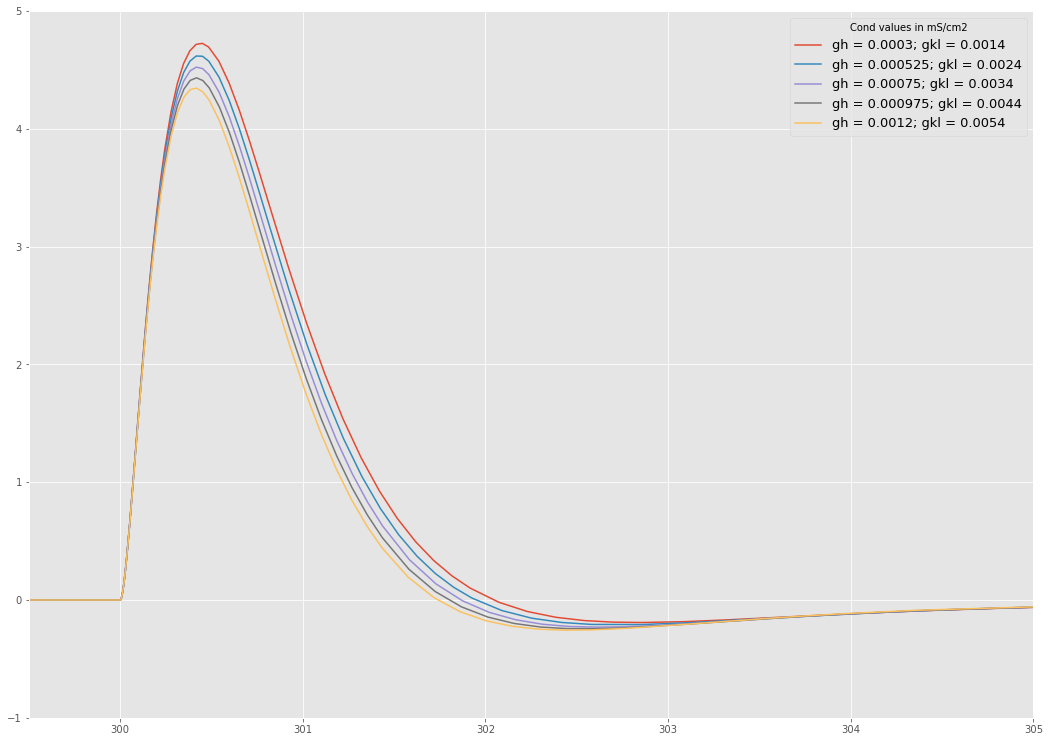

In [54]:
f, ax = subplots(1,1, figsize=(18,13))
for i in range(len(gh['soma'])):
    for d in oc1.dendrites:
        d.gbar_ihsab =    gh['dend'][i]
        d.gbar_kltab =    gkl['dend'][i]
#     oc1.soma.gbar_ihsab = gh['soma'][i]
#     oc1.soma.gbar_kltab = gkl['soma'][i]
#     print oc1.dendrites[0].gbar_ihsab
    records(oc1)

#     ax[0].set_title('Vm along dendrite')
#     ax[0].plot(v_along_dend(oc1, arange(0,1,0.1)), label = str(gh))
#     ax[0].set_xlabel('x coodr along dend')
#     ax[0].legend()
    

#     ax[1].set_title('Soma Vm')
#     ax[1].plot(oc1.Vs['soma'], label = str(gh))
#     ax[1].set_xlabel('Time')
#     ax[1].legend()
#     figure(figsize=(10,1))
#     title('Soma Vm')

    label = 'gh = '+ str(gh['dend'][i]) +'; gkl = ' +str(gkl['dend'][i])
    plot(oc1.Vs['t'],array(oc1.Vs['dend_01'])-array(oc1.Vs['dend_01'])[find_nearest(array(oc1.Vs['t']),299)], label = label)
#     xlabel('Time')
    xlim(299.5,305)
#     ylim(-60.5,-55.5)
    ylim(-1,5)
    legend(loc='best',title='Cond values in mS/cm2', fontsize=13)
#     print width(oc1.Vs['t'], oc1.Vs['soma'],x_boarders=[300,310])
#     print V_peaks(oc1.Vs['t'], oc1.Vs['soma'],x_boarders=[300,310])
    

#     ax[2].set_title('Ax Vm')
#     ax[2].plot(oc1.Vs['ax'],label = str(gh))
#     ax[2].set_xlabel('Time')
#     ax[2].legend()
    
# savefig('EPSP_ofghgkl.pdf')

In [71]:
for d in oc1.dendrites:
        d.g_leak = 0.002

## Изм Gh, Gkl в дендритах. [1/2gbar:2gbar]

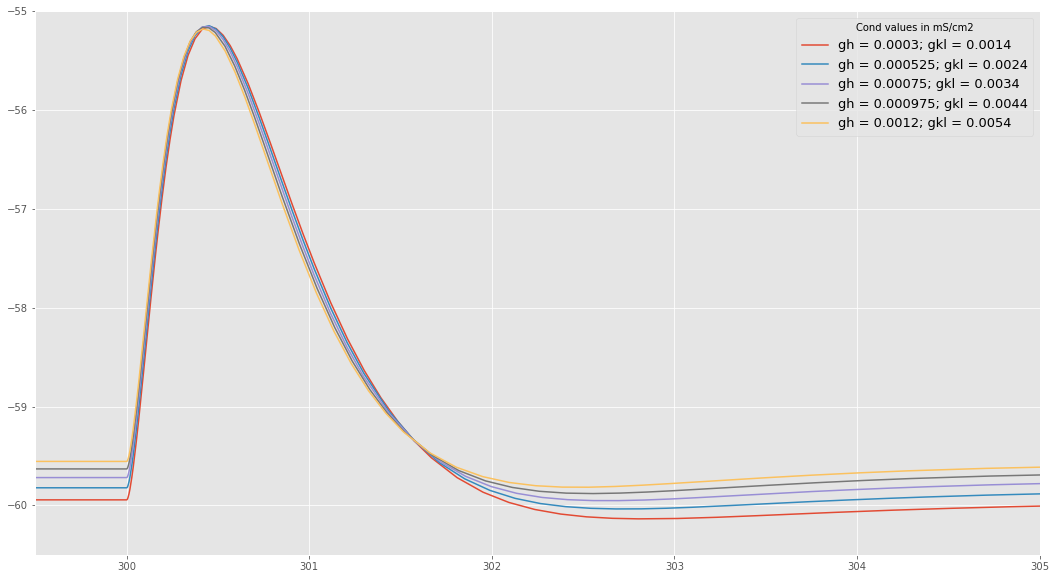

In [78]:
f, ax = subplots(1,1, figsize=(18,10),sharex=True)
for i in range(len(gh['soma'])):
    for d in oc1.dendrites:
        d.gbar_ihsab =    gh['dend'][i]
        d.gbar_kltab =    gkl['dend'][i]

    records(oc1)
    label = 'gh = '+ str(gh['dend'][i]) +'; gkl = ' +str(gkl['dend'][i])
    plot(oc1.Vs['t'],array(oc1.Vs['dend_01']), label = label) #-array(oc1.Vs['dend_01'])[find_nearest(array(oc1.Vs['t']),299)]
    xlim(299.5,305)
    ylim(-60.5,-55)
    legend(loc='best',title='Cond values in mS/cm2', fontsize=13)
    for d in oc1.dendrites:
        d.gbar_ihsab =    0.0006 # initial values
        d.gbar_kltab =    0.0027
# savefig('EPSP_ofghgkl.pdf')

# А если менять только g_leak?

In [ ]:
gl = linspace(0.001,0.004,5)

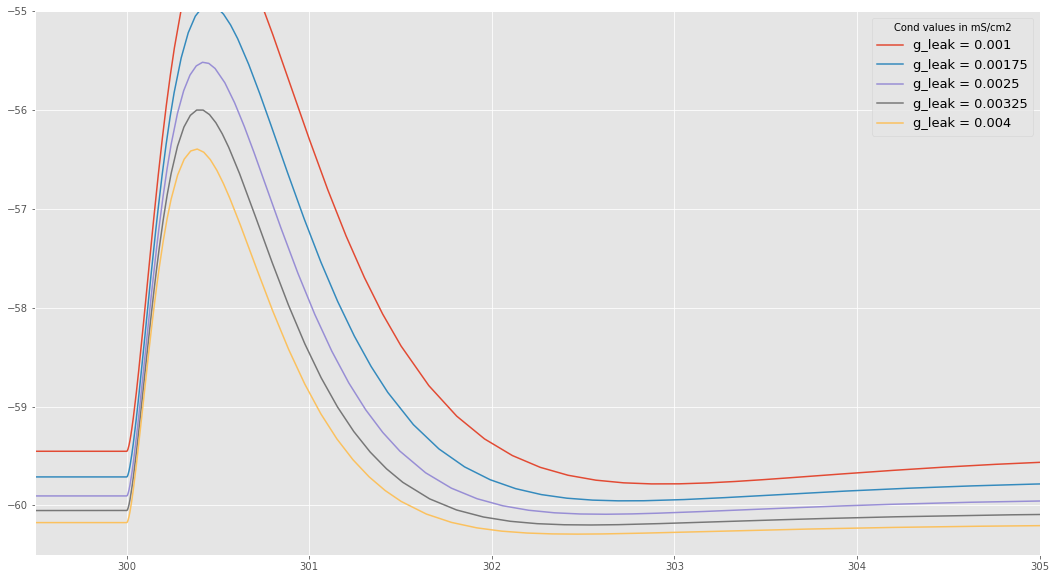

In [81]:
f, ax = subplots(1,1, figsize=(18,10),sharex=True)
for g in gl:
    for d in oc1.dendrites:
        d.g_leak = g
    records(oc1)
    label = 'g_leak = ' + str(g)
    plot(oc1.Vs['t'],array(oc1.Vs['dend_01']), label = label) 
    xlim(299.5,305)
    ylim(-60.5,-55)
    legend(loc='best',title='Cond values in mS/cm2', fontsize=13)
    for d in oc1.dendrites:
        d.g_leak = 0.002 # initial value
    
# savefig('EPSP_ofghgkl.pdf')

## Теперь то же самое, только совместить все кривые в нуль.
 - изм Gh, Gkl
 - изм Gleak

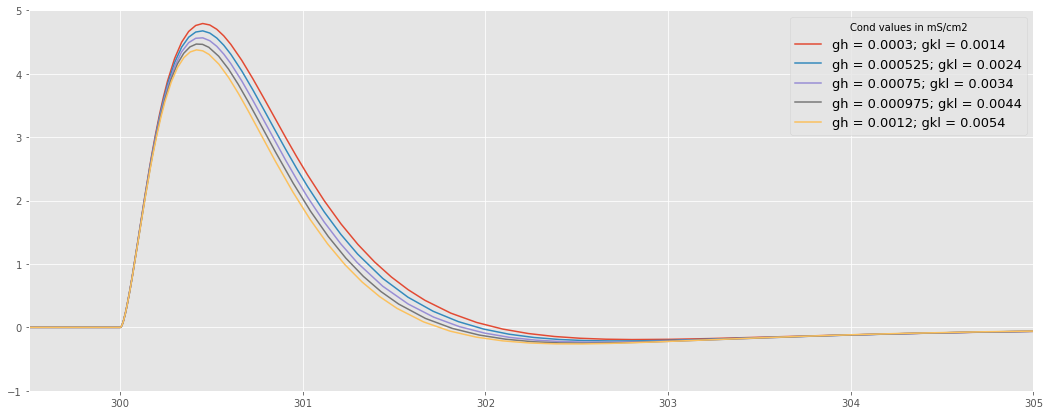

In [93]:
f, ax = subplots(1,1, figsize=(18,7),sharex=True)
for i in range(len(gh['soma'])):
    for d in oc1.dendrites:
        d.gbar_ihsab =    gh['dend'][i]
        d.gbar_kltab =    gkl['dend'][i]

    records(oc1)
    label = 'gh = '+ str(gh['dend'][i]) +'; gkl = ' +str(gkl['dend'][i])
    plot(oc1.Vs['t'],array(oc1.Vs['dend_01'])-array(oc1.Vs['dend_01'])[find_nearest(array(oc1.Vs['t']),299)], label = label) 
    xlim(299.5,305)
    ylim(-1,5)
    legend(loc='best',title='Cond values in mS/cm2', fontsize=13)
    for d in oc1.dendrites:
        d.gbar_ihsab =  0.0006
        d.gbar_kltab =  0.0027


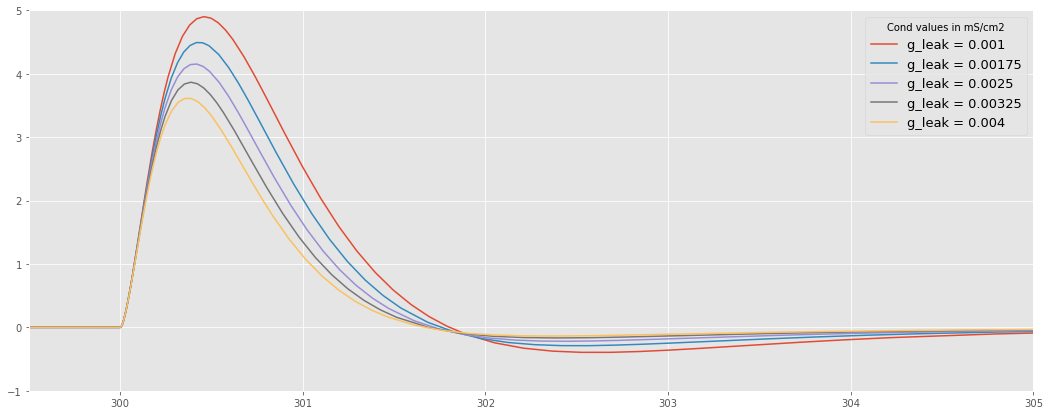

In [91]:
f, ax = subplots(1,1, figsize=(18,7),sharex=True)
for g in gl:
    for d in oc1.dendrites:
        d.g_leak = g
    records(oc1)
    label = 'g_leak = ' + str(g)

    plot(oc1.Vs['t'],array(oc1.Vs['dend_01'])-array(oc1.Vs['dend_01'])[find_nearest(array(oc1.Vs['t']),299)], label = label) 
    xlim(299.5,305)
    ylim(-1,5)
    legend(loc='best',title='Cond values in mS/cm2', fontsize=13)
    for d in oc1.dendrites:
        d.g_leak = 0.002

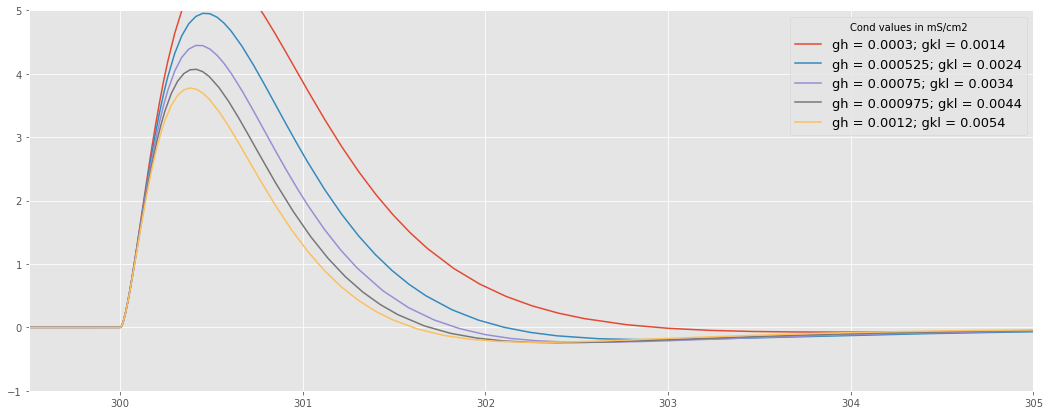

In [94]:
f, ax = subplots(1,1, figsize=(18,7),sharex=True)
for i in range(len(gh['soma'])):
    for d in oc1.dendrites:
        d.gbar_ihsab =    gh['dend'][i]
        d.gbar_kltab =    gkl['dend'][i]
    oc1.soma.gbar_ihsab = gh['soma'][i]
    oc1.soma.gbar_kltab = gkl['soma'][i]

    records(oc1)
    label = 'gh = '+ str(gh['dend'][i]) +'; gkl = ' +str(gkl['dend'][i])
    plot(oc1.Vs['t'],array(oc1.Vs['dend_01'])-array(oc1.Vs['dend_01'])[find_nearest(array(oc1.Vs['t']),299)], label = label) 
    xlim(299.5,305)
    ylim(-1,5)
    legend(loc='best',title='Cond values in mS/cm2', fontsize=13)
    for d in oc1.dendrites:
        d.gbar_ihsab =  0.0006
        d.gbar_kltab =  0.0027

    oc1.soma.gbar_ihsab = 0.0076
    oc1.soma.gbar_kltab = 0.0407

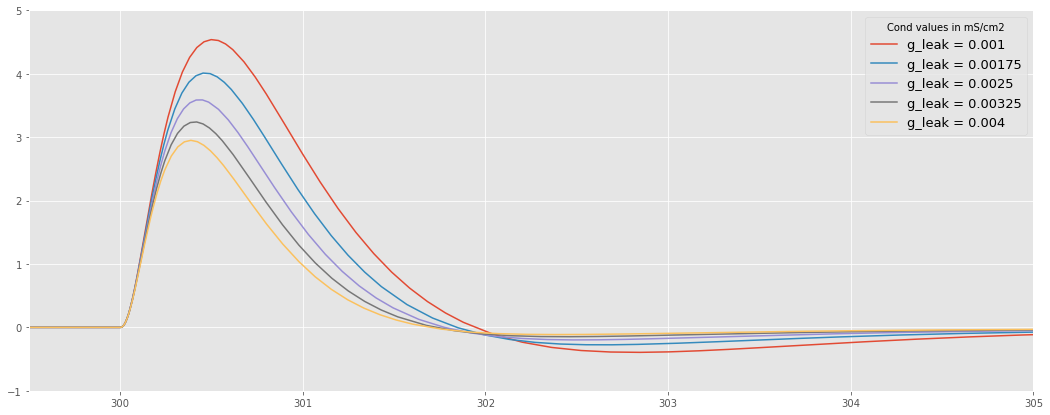

In [96]:
f, ax = subplots(1,1, figsize=(18,7),sharex=True)
for g in gl:
    for d in oc1.dendrites:
        d.g_leak = g
    oc1.soma.g_leak = g
    records(oc1)
    label = 'g_leak = ' + str(g)

    plot(oc1.Vs['t'],array(oc1.Vs['dend_01'])-array(oc1.Vs['soma'])[find_nearest(array(oc1.Vs['t']),299)], label = label) 
    xlim(299.5,305)
    ylim(-1,5)
    legend(loc='best',title='Cond values in mS/cm2', fontsize=13)
    for d in oc1.dendrites:
        d.g_leak = 0.002
    oc1.soma.g_leak = 0.002

In [26]:
def plot_EPSPsum(cell,sec,gh,gkl,plotepsp=0,modeplt=None, mode='linear', chngLeak=None, plot_par=0):
    """
    modeplt = None => raw data plotted; = 'to_zero => shift to zero.
    chngLeak = 'chng' => erev_leaks are calculated that fit Vm spatial profile to Vm initial.
    mode -- mode in residual_d() func -- 'linear'/ 'exp'/ ... erev_leak dend profile func.
    """
    f, ax = subplots(1,1, figsize=(18,7),sharex=True)
    tst = cell.afib.start
    
    v_inits = {'dnd':v_along_dend(cell, arange(0,1,0.1)),
               'sma':cell.soma.v,
               'axn':cell.ax_init.v}
    
    parkeys = ['dvdt', 'width', 'Vmax', 'Vsag'] + ['0.5', '0.75']
    acc_pars = {key:[] for key in parkeys} # accumulate parameters' values
   
    for i in range(len(gh['soma'])):
        for d in cell.dendrites:
            d.gbar_ihsab =    gh['dend'][i]
            d.gbar_kltab =    gkl['dend'][i]
        cell.soma.gbar_ihsab = gh['soma'][i]
        cell.soma.gbar_kltab = gkl['soma'][i]
        
        #----------- Calculate erev_leaks in cell sections that => Vm(gbar = init) = Vm(changed gbar)
        if chngLeak == 'chng': 
            eps=1
            out = minimize(residual_d, p, args=(cell, v_inits, eps, mode))
    #         print out.params
            residual_d(out.params, cell=cell, v_inits=v_inits, eps=eps, mode=mode, mode2='calc') # set new erev_leak distrib
            ### good to write out.params into a txt + date + gh,gkl values
        
        pars = params(cell, sec) # do records => cell.Vs exists
        
        for k in pars.keys(): # keys are parameter names, 'dvdt' etc.
            acc_pars[k].append(pars[k][0])
            print acc_pars
        if modeplt == None:
            data = array(cell.Vs[sec]) # 'raw' data
        elif modeplt == 'to_zero':
            data = array(cell.Vs[sec])-array(cell.Vs[sec])[find_nearest(array(cell.Vs['t']),tst)] # shifted to zero
        
        if sec == 'soma':
            lbl = 'gh = '+ str(gh['soma'][i]) +'; gkl = ' +str(gkl['soma'][i])
        if sec == 'dend_01' or sec == 'dend_09':
            lbl = 'gh = '+ str(gh['dend'][i]) +'; gkl = ' +str(gkl['dend'][i])
        if sec == 'ax':
            lbl = 'axon'

        # -------- plot epsp
        if plotepsp ==1:
            title(sec)
            plot(cell.Vs['t'], data, label = lbl) 
            xlim(tst-0.5,tst+5)
    #         ylim(-65,-50)
    #         ylim(-1,7)

            legend(loc='best',title='Cond values in mS/cm2', fontsize=13)
            xlabel('Time, ms')
            ylabel('Vm, mV')

        #------ return all gbars back
        for d in cell.dendrites:
            d.gbar_ihsab =  0.0006
            d.gbar_kltab =  0.0027
            
        cell.soma.gbar_ihsab = 0.0076
        cell.soma.gbar_kltab = 0.0407
        
        #------ Parameter values

    if plot_par == 1:
        f=figure(figsize=(7,3))
        title(sec)
        for key, val in acc_pars.items():
            plot(linspace(0.5,2,len(gh['soma'])), val/array(val).max(), 'o-', label=key)
        legend()
        xlabel('Gbar/Gbar_init')
#     return

In [17]:
oc = OctopusCell(Ndendseg=501)

In [47]:
oc.add_several_syn(locs = linspace(0,1,75),gsyn=1.,dnm=[0,1,2,3],
                    afibp={'aud_npulses':1,'aud_start':300,'aud_jitter':0,'aud_rate':2})

In [28]:
h.cvode_active(1)
h.cvode.atol(1e-3)


1e-10

In [26]:
h.tstop=400

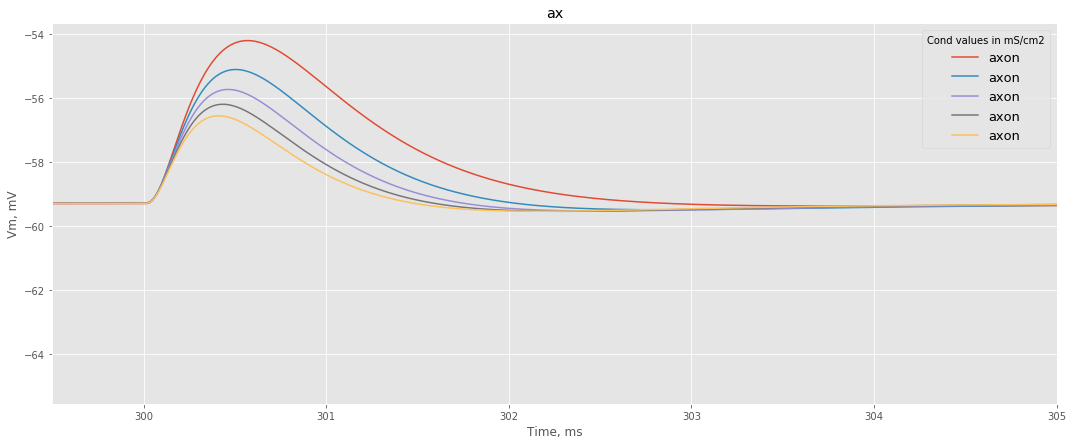

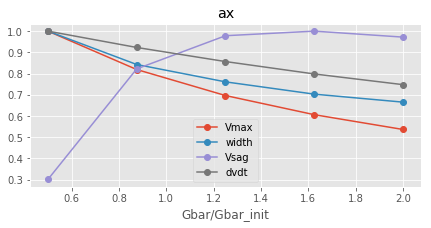

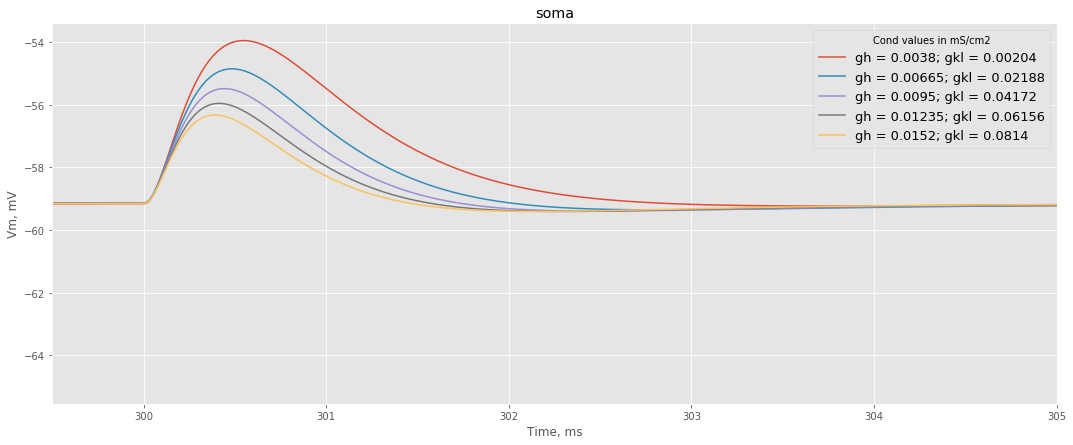

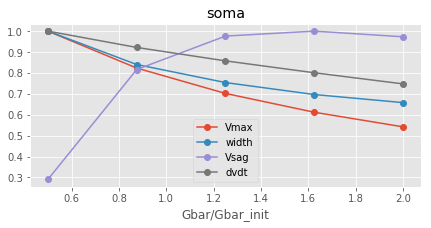

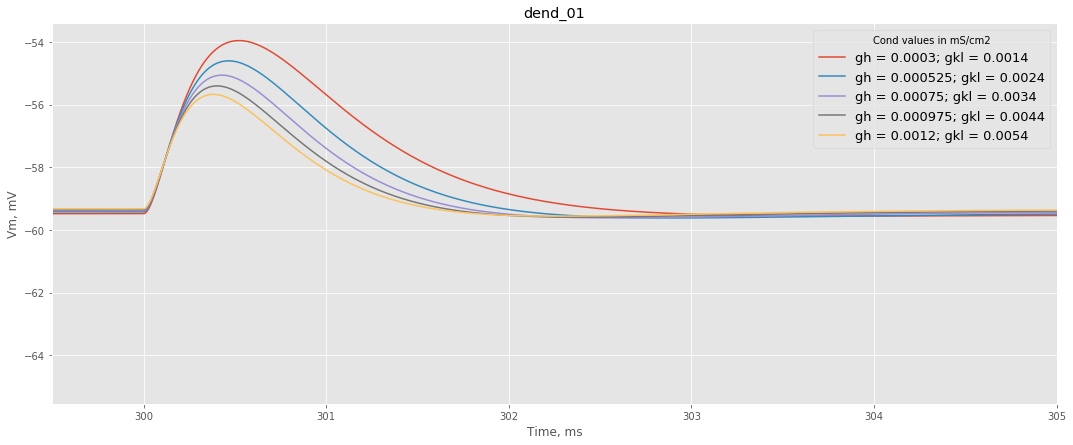

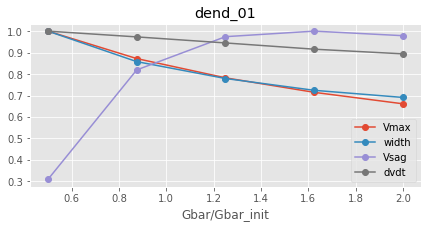

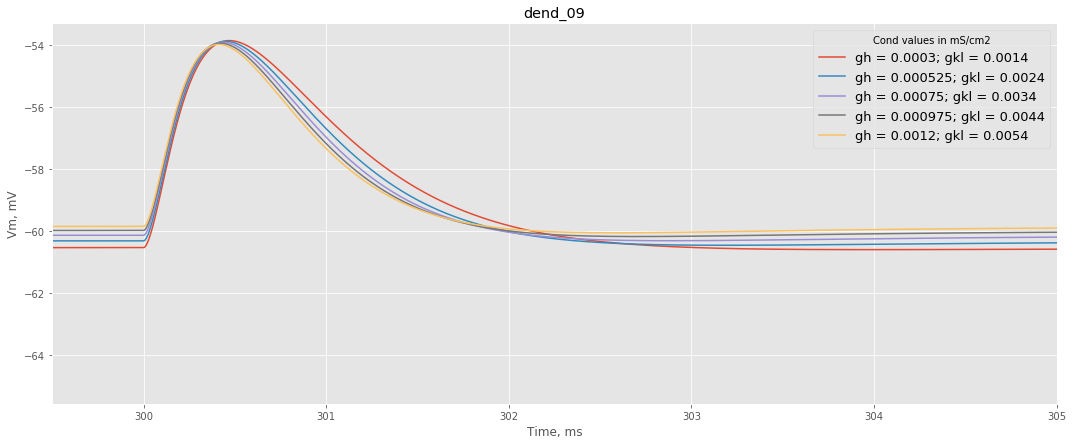

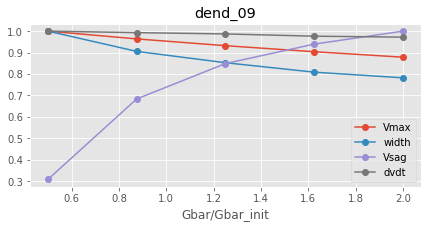

In [29]:
# h.cvode.atol(1e-10)
for sec in ['ax','soma','dend_01','dend_09']:
    plot_EPSPsum(oc1,sec,gh,gkl, plot_par=1)

{'Vmax': [0.066762141916463236], 'width': [], 'Vsag': [], 'dvdt': []}
{'Vmax': [0.066762141916463236], 'width': [1.5302843059184852], 'Vsag': [], 'dvdt': []}


KeyError: '0.5'

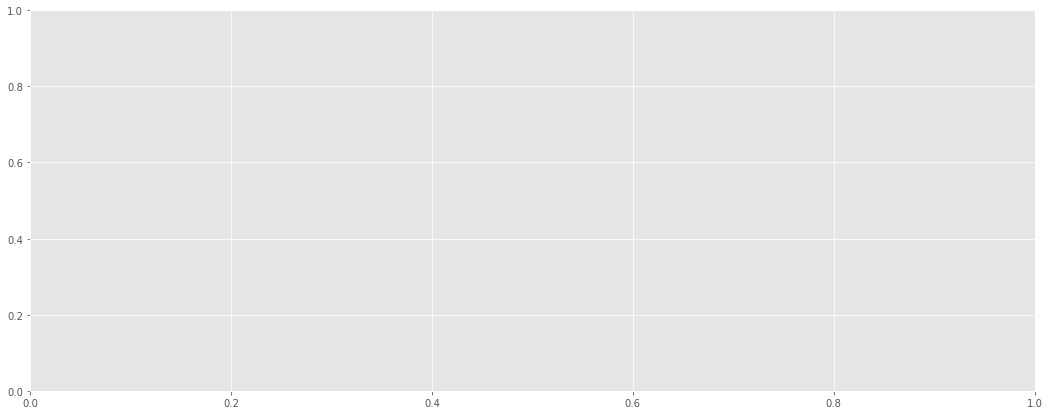

In [25]:
# plu
h.cvode.atol(1e-1)
for sec in ['ax','soma','dend_01','dend_09']:
    plot_EPSPsum(oc,sec,gh,gkl, plot_par=0)

In [99]:
gh = {'soma':linspace(0.0038,0.0152,5),
     'dend': linspace(0.0003,0.0012,5)}
gkl = {'soma':linspace(0.00204,0.0814,5),
      'dend': linspace(0.0014,0.0054,5)}

#   soma_gbar_Ikl = 0.0407, # mS/cm^2
#                  soma_gbar_Ih = 0.0076,   # mS/cm^2
#                  dend_gbar_Ikl = 2.7, 

# Линейный градиент Gh, Gkl

### величины Gh, Gkl в соме неизменны

In [31]:
# kl_factor = oc1.soma.gbar_kltab/oc1.dendrites[0].gbar_kltab
# h_factor = oc1.soma.gbar_ihsab/oc1.dendrites[0].gbar_ihsab

15.074074074074073

In [31]:
par = {'kh':linspace(0.0009,-0.0009,5),'bh': linspace(0.0003,0.0012,5),'kkl':linspace(0.004,-0.004,5),'bkl':linspace(0.0014,0.0054,5)}

In [29]:
x= linspace(0,1,10)


In [96]:
h.cvode.atol(1e-10)

1e-10

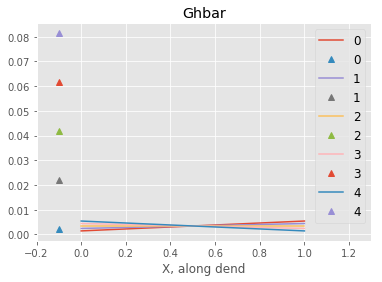

In [38]:
for i in range(5):
    plot(x,par['bkl'][i] + x*par['kkl'][i], label=i)
    plot(-0.1,gkl['soma'][i], '^', label=i)
xlim(-.2,1.3)
xlabel('X, along dend')
title('Ghbar')
legend(fontsize=12)

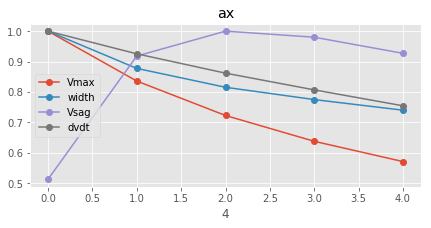

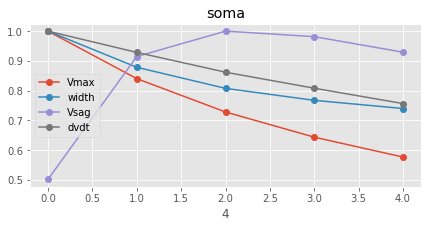

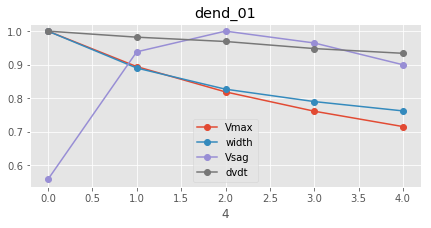

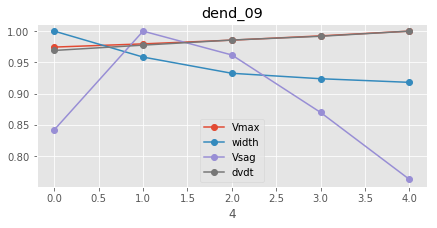

In [57]:
# with soma gbars changed

for sec in ['ax','soma','dend_01','dend_09']:
    parkeys = ['dvdt', 'width', 'Vmax', 'Vsag']
    acc_pars = {key:[] for key in parkeys} # accumulate parameters' values
    for i in range(5):
        # ----- set gh and gkl distribution
        for seg in chain(*oc.dendrites):
            seg.gbar_ihsab = par['bh'][i] + par['kh'][i]*seg.x
            seg.gbar_kltab = par['bkl'][i] + par['kkl'][i]*seg.x
        oc.soma.gbar_ihsab = gh['soma'][i]
        oc.soma.gbar_kltab = gkl['soma'][i]
        

        # ----- parameters recs
        pars = params(oc, sec) # do records => cell.Vs exists
        for k in pars.keys(): # keys are parameter names, 'dvdt' etc.
            acc_pars[k].append(pars[k][0])

        #------ return all gbars back
        for d in oc1.dendrites:
            d.gbar_ihsab =  0.0006
            d.gbar_kltab =  0.0027
        oc.soma.gbar_ihsab = 0.0076
        oc.soma.gbar_kltab = 0.0407

    
    f=figure(figsize=(7,3))
    title(sec)
    for key, val in acc_pars.items():
        plot(range(5), val/array(val).max(), 'o-', label=key)
    legend()
    xlabel(i)

# А как будет с одним впсп?

In [20]:
oc = OctopusCell(Ndendseg=501)

In [21]:
afib = oc.set_afib(aud_npulses=1,aud_start=300)
oc.add_single_syn(loca=1.,afib=afib,gsyn=1)

(<hoc.HocObject at 0x1192a44f8>,
 0)

In [22]:
h.cvode_active(1)
h.cvode.atol(1e-10)

1e-10

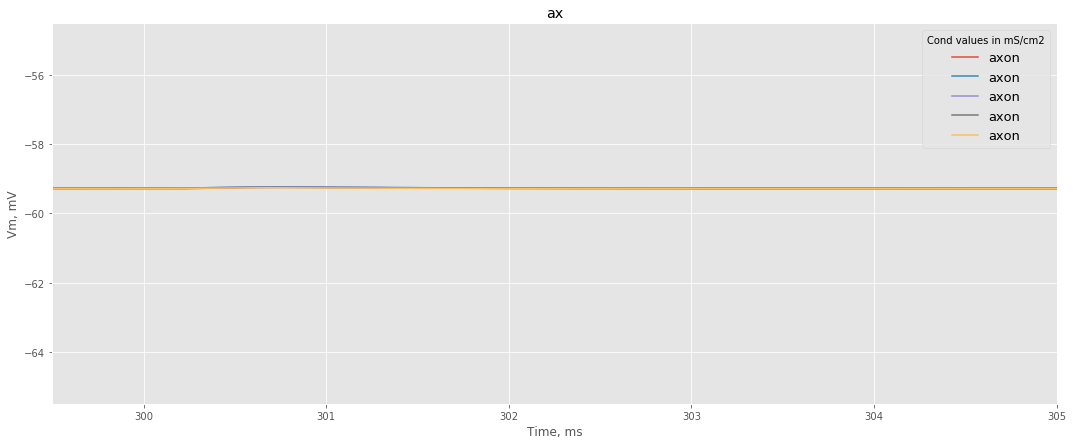

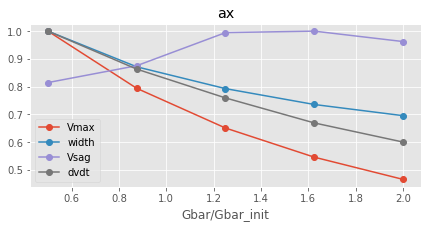

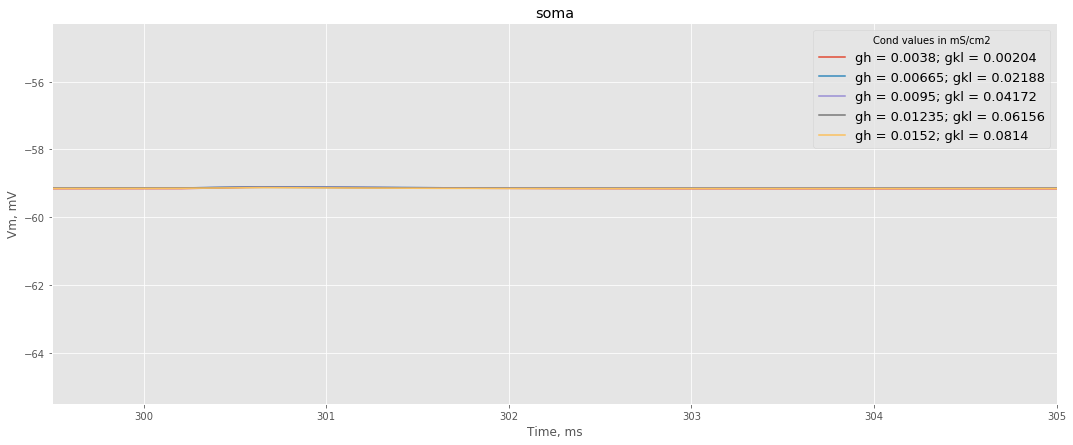

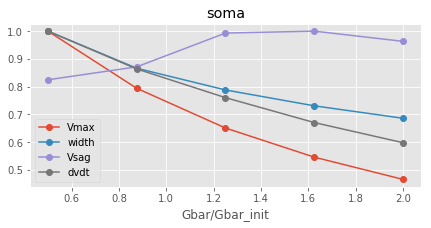

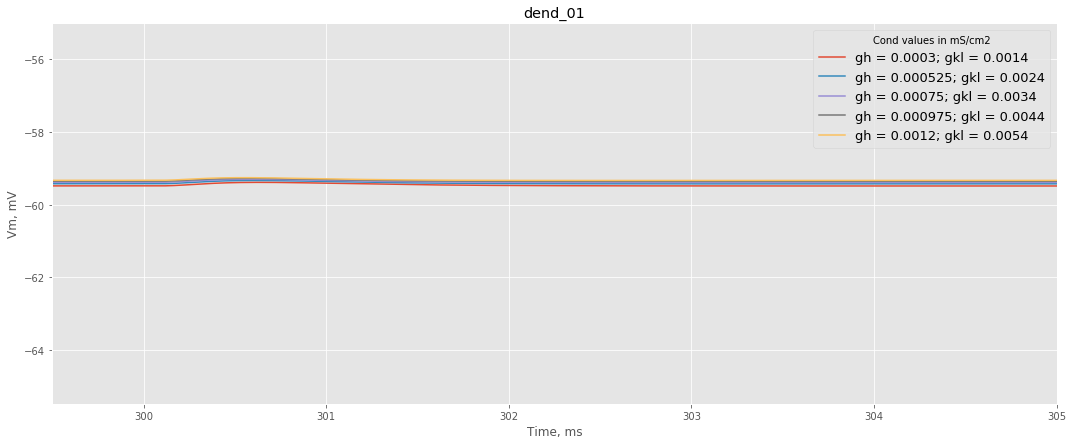

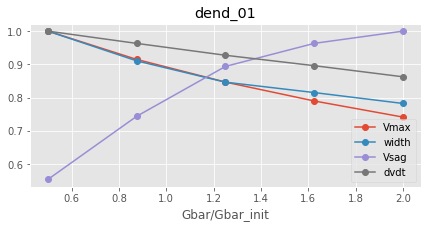

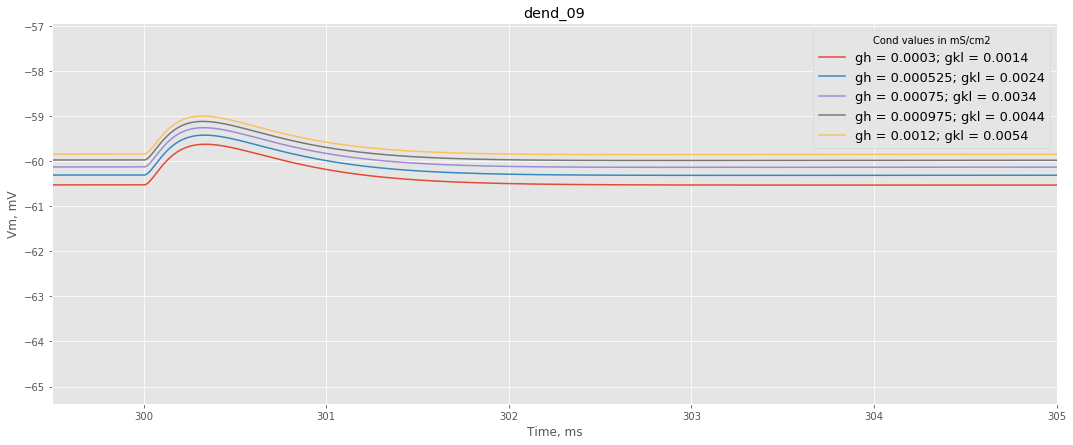

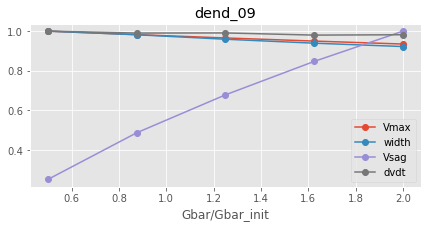

In [27]:
# h.cvode.atol(1e-10)
for sec in ['ax','soma','dend_01','dend_09']:
    plot_EPSPsum(oc,sec,gh,gkl, plot_par=1)

# А как delay_times(х) изменится при изменении Gh, Gkl в дендритах? в соме?

In [12]:
#### To calculate single synapse delay time dependance on its distance from the soma 
#### SAVED to 'delays.txt'

# oc = OctopusCell(Ndendseg=501)
h.cvode_active(1)
h.cvode.atol(1e-5)

1e-05

In [10]:
oc = OctopusCell(Ndendseg=501)

In [11]:
h.tstop =400

In [9]:
par = {'kh':linspace(0.0009,-0.0009,3),
       'bh': linspace(0.0003,0.0012,3),
       'kkl':linspace(0.004,-0.004,3),
       'bkl':linspace(0.0014,0.0054,3)}

CPU times: user 1min 15s, sys: 244 ms, total: 1min 16s
Wall time: 1min 16s
***
Total travelling wave delay = 0.00 ms
***
CPU times: user 31.4 s, sys: 129 ms, total: 31.5 s
Wall time: 31.7 s
***
Total travelling wave delay = 0.00 ms
***
CPU times: user 41.3 s, sys: 197 ms, total: 41.5 s
Wall time: 42.1 s
***
Total travelling wave delay = 0.00 ms
***


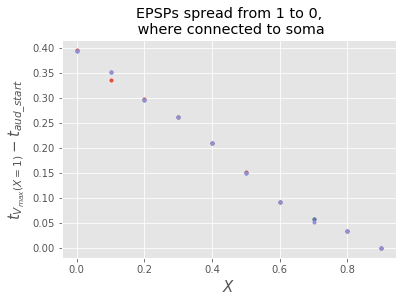

In [18]:
for i in range(3):
    # ----- set gh and gkl distribution
    for seg in chain(*oc.dendrites):
        seg.gbar_ihsab = par['bh'][i] + par['kh'][i]*seg.x
        seg.gbar_kltab = par['bkl'][i] + par['kkl'][i]*seg.x
    acc, acc1=oc.find_delays(locs=arange(0,1,0.1),dnm=1,v_init=-59.6)

    acc[1] = acc[1]-acc[1][-1]
    acc[1] = array(acc[1]).max()-acc[1]

    plot(acc[0],acc[1],'.')
    title('EPSPs spread from 1 to 0,\n where connected to soma')
    ylabel('$t_{V_{max}^{X=0}-t_{aud\_start}$', fontsize=15)
    xlabel('$X$', fontsize=15)
    print '***\nTotal travelling wave delay = %.2f ms\n***'%(acc[1].max()-acc[1][0])
    
    for d in oc.dendrites:
        d.gbar_ihsab =  0.0006
        d.gbar_kltab =  0.0027

    #### Write the delays into a txt file 'delays.txt'
    #### SAVED to 'delays.txt'
    # with open('delays.txt','w') as f:
    #     for i in [0,1]:
    #         f.write("\t".join(map(lambda x: str(x), acc[i])) + "\n")
    #     f.close()

In [1]:
%store -r datar_ord

no stored variable datar_ord
